#  Tutorial for the Week 9
Course: Artificial Intelligence (COMP6065001)

<b>Outline:</b>
1. Deep Learning Pipeline
2. Home assignment

## 1. DL Pipeline for NLP

The outline of a generic DL pipeline is as follows: 
1. Task specification
2. Dataset acquisition
3. Dataset preprocessing
4. Dataset observation
5. Feature extraction
6. Model selection
7. Model design
8. Model training
9. Model evaluation

### 1. Task specification

Our task is to implement a deep learning model for Indonesian news classification. <br>
So, the input to the model will be Indonesian news stored in raw text format, <br>
and the goal is to assign each news into five categories: 'bola', 'news', 'bisnis', 'tekno', 'otomotif'

We will implement a DL model using Transformers, <br>
in fact, we will fine-tune a pretrained BERT model
for our task.

Pretrained BERT model can be found here: 
- https://indolem.github.io/IndoBERT/
- https://huggingface.co/indolem/indobert-base-uncased/blob/main/README.md

#### Import pretrained BERT Model and BERT Tokenizer

In [29]:
from transformers import AutoTokenizer, AutoModel

# Download the pretrained BERT model from Hugging Face
tokenizer = AutoTokenizer.from_pretrained("indolem/indobert-base-uncased")
bert = AutoModel.from_pretrained("indolem/indobert-base-uncased", return_dict=False)

# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

### 2. Dataset acquisition

The dataset of Indonesian News that we will be using is availeble via the link: <br>
https://github.com/andreaschandra/indonesian-news.

The baseline code for text classification using Multinomial Naive Bayes model <br>
can be also find in the link above.

The dataset is saved in the folder <b>data</b> inside the project folder.<br>
There are two files <i>training.res</i> and <i>testing.res</i>.

### 3. Dataset preprocessing

In [82]:
# Import the necessary libraries
import glob
import re
import pickle
import collections
from tqdm import tqdm

import pandas as pd
import numpy as np
import seaborn as sns

from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
import transformers
from transformers import BertModel, BertTokenizerFast

%matplotlib inline

#### Load dataset

In [106]:
# Data folder
data_path = 'data/'
files = glob.glob(data_path + '/*')

# Print the files read
print("Files: ", files)
print("------------------------------------------------------------")

# Read train and test data
train = pickle.load(open(files[1], 'rb'))
test = pickle.load(open(files[0], 'rb'))

# Print raw data
print("Text: ", train[0][0])
print("------------------------------------------------------------")
print("Category:", train[1][0])
print("------------------------------------------------------------")

# Convert data to DataFrame format
d_train = pd.DataFrame({'content': train[0], 'label': train[1]})
d_test = pd.DataFrame({'content': test[0], 'label': test[1]})

# Print formatted data
pd.DataFrame(d_test, index=[10,42,44,50])

Files:  ['data/testing.res', 'data/training.res']
------------------------------------------------------------
Text:  Liputan6.com, London - Lee Dixon khawatir Arsenal tak bisa merekrut Denis Suarez secara permanen musim panas nanti. Pasalnya sejauh ini, Suarez hanya menjadi cadangan bagi The Gunners.

Suarez dipinjam Arsenal dari Barcelona, Januari lalu. The Gunners juga bisa membelinya pada akhir musim nanti jika permainannya memuaskan.

Namun sejauh ini Suarez tak menjadi pilihan utama di Arsenal. Manajer Unai Emery baru memberinya kesempatan bermain selama 85 menit.

"Emery mungkin tahu kualitas Suarez. Dia tahu Suarez pemain yang dibutuhkannya," kata Dixon seperti dilansir Evening Standard.

"Namun dari sudut pandang Suarez, dia pasti berpikir untuk apa pindah kalau tidak bermain. Jadi mungkin saja dia akan menolak Arsenal," katanya menambahkan.
------------------------------------------------------------
Category: bola
------------------------------------------------------------


,content,label
10,"Liputan6.com, London - Bek Arsenal, Sokratis P...",bola
42,"Liputan6.com, Jakarta - Laju Indeks Harga Saha...",bisnis
44,"Liputan6.com, Jakarta - Para vendor meyakini p...",tekno
50,"Liputan6.com, Jakarta - Malam di Kota Sampit, ...",news


In [126]:
# convert labels to numbers
d_train['label'] = d_train['label'].replace(['bola', 'news','bisnis', 'tekno', 'otomotif'],[0,1,2,3,4])
d_test['label'] = d_test['label'].replace(['bola', 'news','bisnis', 'tekno', 'otomotif'],[0,1,2,3,4])
d_train.head()

,content,label,text
0,"Liputan6.com, London - Lee Dixon khawatir Arse...",0,london lee dixon khawatir arsenal tak bisa mer...
1,"Liputan6.com, Jakarta - Kasus dugaan penganiay...",1,jakarta kasus dugaan penganiayaan terhadap dua...
2,"Liputan6.com, Jakarta Menanggapi aksi eks peke...",2,jakarta menanggapi aksi eks pekerja freeport i...
3,"Liputan6.com, Medan - Sebanyak 81 kendaraan 4x...",0,medan sebanyak kendaraan 4x4 dan motor telah t...
4,"Liputan6.com, Jakarta Indonesia akan melawan T...",0,jakarta indonesia akan melawan thailand final ...


#### Data cleaning

In [127]:
# Function for cleaning the data:
# - remove the short words (len < 3)
# - remove non-alphanumeric words
# - remove stop words (if required)
def cleaning(text, stopword = None):
    word_list = word_tokenize(text.lower())
    word_list = [word for word in word_list if len(word) > 2]
    word_list = [word for word in word_list if word.isalnum()]
    if stopword == None:
        text = ' '.join(word_list)
    else:
        word_list = [word for word in word_list if word not in stopword]
        text = ' '.join(word_list)
                
    return text

In [128]:
for i in tqdm(range(len(d_train))):
    d_train.loc[i, 'text'] = cleaning(d_train.loc[i, 'content'], stopword=None)

100%|███████████████████████████████████████████████████████████████████████████████████████| 6127/6127 [00:03<00:00, 1543.99it/s]


In [129]:
for i in tqdm(range(len(d_test))):
    d_test.loc[i, 'text'] = cleaning(d_test.loc[i, 'content'], stopword=None)

100%|███████████████████████████████████████████████████████████████████████████████████████| 2627/2627 [00:01<00:00, 1546.72it/s]


In [130]:
d_train['text'][0]

'london lee dixon khawatir arsenal tak bisa merekrut denis suarez secara permanen musim panas nanti pasalnya sejauh ini suarez hanya menjadi cadangan bagi the gunners suarez dipinjam arsenal dari barcelona januari lalu the gunners juga bisa membelinya pada akhir musim nanti jika permainannya memuaskan namun sejauh ini suarez tak menjadi pilihan utama arsenal manajer unai emery baru memberinya kesempatan bermain selama menit emery mungkin tahu kualitas suarez dia tahu suarez pemain yang dibutuhkannya kata dixon seperti dilansir evening standard namun dari sudut pandang suarez dia pasti berpikir untuk apa pindah kalau tidak bermain jadi mungkin saja dia akan menolak arsenal katanya menambahkan'

#### Split data into train, test, and validation sets

In [125]:
train_text, val_text, train_labels, val_labels = train_test_split(d_train['text'], d_train['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.1, 
                                                                    stratify=d_train['label'])
test_text = d_test["text"]
test_labels = d_test["label"]

print("Train: ", train_labels.shape)
print("Test", test_labels.shape)
print("Val:", val_labels.shape)

Train:  (5514,)
Test (2627,)
Val: (613,)


### 4. Dataset observation

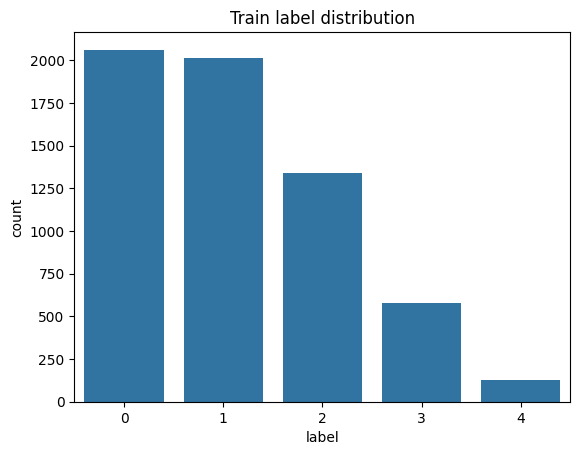

In [131]:
# Distribution of train data within the categories
train_plot = sns.barplot(y = d_train.label.value_counts(), x = d_train.label.value_counts().index).set_title('Train label distribution')
train_plot.get_figure().savefig('train_dist.png')

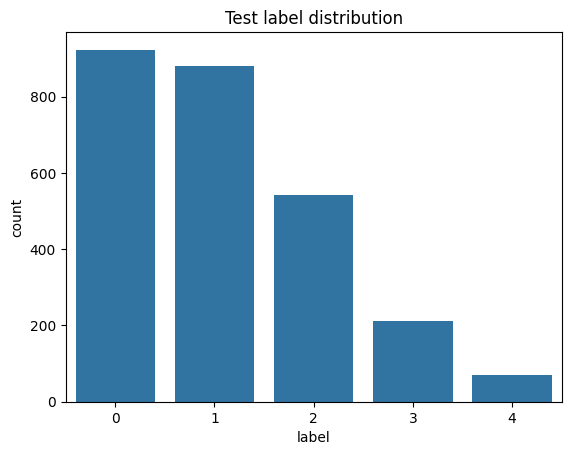

In [132]:
# Distribution of train data within the categories
test_plot = sns.barplot(y = d_test.label.value_counts(), x = d_test.label.value_counts().index).set_title('Test label distribution')
test_plot.get_figure().savefig('test_dist.png')

### 5. Feature extraction

#### Tokenization

In [133]:
# convert sample data to numbers
text = ["Silakan diganti dengan text apa saja.","Barcelona punya pengalaman buruk saat membeli pemain bertahan belia dari Brasil."]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)
print(sent_id)

{'input_ids': [[3, 12082, 7544, 1545, 16969, 2064, 2037, 18, 4, 0, 0, 0, 0, 0], [3, 7727, 3307, 4167, 4088, 1759, 4443, 2494, 4270, 16864, 1542, 5926, 18, 4]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [134]:
# Maximum text (sequence) length
# if text > max_seq_len, text will be cut
# if text < max_seq_len, text will be paddd with blank symbol
max_seq_len = 300

# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    padding='max_length',
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    padding='max_length',
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    padding='max_length',
    truncation=True,
    return_token_type_ids=False
)

#### Convert Integer Sequences to Tensors

In [135]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

#### Create DataLoaders

In [119]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

### Train
# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

### Val
# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

### Test
# wrap tensors
test_data = TensorDataset(test_seq, test_mask, test_y)

# sampler for sampling the data during training
test_sampler = SequentialSampler(test_data)

# dataLoader for validation set
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size=batch_size)

### 6. Model selection



We will implement a Tranformer model based on pretrained BERT model. <br>
Basically, we will add one more layer on top of the BERT model, <br>
and use the output of this layer to classify the input into 5 categories.

You can find more information about Transformers and BERT models here:
- https://machinelearningmastery.com/the-transformer-model/
- https://machinelearningmastery.com/a-brief-introduction-to-bert/

### 7. Model design

#### Model definition

In [120]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,5)
      
      # dense layer 2 
      # adjust the input and output numbers  
      # self.fc2 = nn.Linear(512,5)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      # pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)  
      
      x = self.dropout(cls_hs)
    
      x = self.fc1(x)

      x = self.relu(x)

      # uncomment if you need more layers
      # x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

#### Setup the model

In [136]:
# define device and check if there is CUDA-device
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to device (GPU/CPU)
model = model.to(device)

# define the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-5)

GPU not available, CPU used


### 8. Model training

#### Loss Function

In [122]:
from sklearn.utils.class_weight import compute_class_weight

# compute the class weights
class_wts = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
print(class_wts)

# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights)

[0.59386107 0.60760331 0.91518672 2.12076923 9.42564103]


#### Training function

In [123]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step, batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
      
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()   
      
    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

#### Evaluation function

In [137]:
# function for evaluating the model
def evaluate(dataloader):
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      # elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

#### Start training 

In [60]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

# number of training epochs
epochs = 1

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate(val_dataloader)
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 1
  Batch    50  of    173.
  Batch   100  of    173.
  Batch   150  of    173.

Evaluating...

Training Loss: 1.611
Validation Loss: 1.599


### 9. Model evaluation

In [138]:
# load weights of the saved model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path), strict=False)

<All keys matched successfully>

In [77]:
avg_loss, total_preds = evaluate(test_dataloader)
print(total_preds.shape)
print(avg_loss)


Evaluating...
  Batch    50  of     83.
(2627, 5)
1.594307277576033


In [139]:
print(total_preds.shape)

# model's performance
preds_max = np.argmax(total_preds, axis = 1)
print(classification_report(test_y, preds_max))

(2627, 5)
              precision    recall  f1-score   support

           0       0.35      0.10      0.16       923
           1       0.00      0.00      0.00       880
           2       0.14      0.08      0.10       542
           3       0.07      0.41      0.13       212
           4       0.05      0.69      0.10        70

    accuracy                           0.10      2627
   macro avg       0.12      0.25      0.10      2627
weighted avg       0.16      0.10      0.09      2627



/Users/yessen/Documents/_BINUS/Teaching/COMP6065001_AI2023/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yessen/Documents/_BINUS/Teaching/COMP6065001_AI2023/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yessen/Documents/_BINUS/Teaching/COMP6065001_AI2023/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_div

In [140]:
# confusion matrix
pd.crosstab(test_y, preds_max)

col_0,0,2,3,4
row_0,,,,
0,93,164,546,120
1,105,81,282,412
2,46,43,217,236
3,15,12,86,99
4,3,2,17,48


## 2. Home assignment

In this assignment, you need to implement a baseline DL pipeline <br>
for the task of your project. For that, you have to 1) identify your task <br>
and 2) find/prepare a dataset. This assignment will be a pre-step <br>
towards your final project. So, once you select the task,<br>
you will not be allowed to change it until the end of the course.<br>
However, you are allowed to use any dataset for your task.<br>

<b>Requirements:</b> <br>
You have to follow the DL pipeline outlined above for your task. <br>
Although some steps might not be applicable for your task and dataset pair <br>
(e.g.: the dataset has only features, or pre-trained model is not used),<br>
but the task specification, model training and model evaluation steps are mandatory.<br>

<b>Deadline</b>: 23:59, 29.11.2023 <br>
<b>Late submissions</b>: 20% point deduction will be applied.
